In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from HMC.TrueDistributions import *
from HMC.ChainMakers import *
tf.experimental.numpy.experimental_enable_numpy_behavior()

mvn = MVN(tf.constant([0,0],dtype=tf.float32), tf.constant([[5,1],[0,1]],dtype=tf.float32))

chain_maker = HamiltonianChainMaker(mvn,n=10**4,step_size=.06)

print(chain_maker)

In [ ]:
chain_maker.getOutput()

array([[-3.1644025 ,  0.6573005 ],
       [-3.1644025 ,  0.6573005 ],
       [ 1.7323039 ,  0.52145135],
       ...,
       [ 3.6960652 ,  0.5631011 ],
       [ 3.6960652 ,  0.5631011 ],
       [-4.4639974 , -0.05296713]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
def plot_chain_errors(actual_mean,actual_cov,chain,title,upto=7000):
    means = [chain[:i].mean(axis=0) for i in range(2,upto,4)]
    covs = [np.cov(chain[:i].T) for i in range(2,upto,4)]
    print(means[5],covs[5])
    mean_errors = [np.abs(actual_mean - mean).mean() for mean in means]
    cov_errors = [np.abs(actual_cov - cov).mean() for cov in covs]
    plt.plot([*range(2,upto,4)],mean_errors,label='mean estimation error')
    plt.plot([*range(2,upto,4)],cov_errors,label='covariance estimation error')
    plt.xlabel('Iteration number')
    plt.ylabel('Error')
    plt.legend()
    plt.title(title)
    plt.show()



In [ ]:
s = 10
large_scale_mean = np.abs(np.random.normal(0,1,s))
large_scale_cov = np.eye(s)*np.abs(np.random.normal(0,1,s))
large_scale_cov += large_scale_cov.T
print(large_scale_mean,large_scale_cov)

[0.28152731 1.59475174 0.75452675 0.97079731 1.58908566 0.25882523
 0.05319915 1.49267772 1.16413404 2.23920761] [[1.43020278 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         1.11633452 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.34657811 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.73720327 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.62924862 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.46778115
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5270997  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.69939091 0.         0.        ]
 [0.         0.        

mean:1.0452  covariance:[[ 1.40426979e+00  1.30282250e-03  2.03388957e-03 -5.23671699e-02
  -3.95694016e-02 -1.30071137e-02 -7.42823419e-03 -3.05869615e-02
   4.49218042e-02 -6.11937655e-03]
 [ 1.30282250e-03  1.11554732e+00 -6.33035772e-03  2.25166878e-02
   4.26780422e-02  6.69118936e-03  7.11470215e-02  7.64286190e-02
   2.93736625e-02  8.16076772e-03]
 [ 2.03388957e-03 -6.33035772e-03  3.47738376e-01 -3.19398525e-03
   4.31219335e-03  6.11731454e-03 -2.95550593e-03  2.55879423e-03
  -9.15630125e-03 -1.97943933e-03]
 [-5.23671699e-02  2.25166878e-02 -3.19398525e-03  1.69936792e+00
   2.09054473e-02  2.84886355e-02 -2.33812327e-03  7.77727916e-04
   1.80067236e-02 -4.67741938e-03]
 [-3.95694016e-02  4.26780422e-02  4.31219335e-03  2.09054473e-02
   7.35741538e-01 -3.22122661e-02  1.58000585e-02 -3.14529956e-02
   1.68260160e-02 -4.66573044e-03]
 [-1.30071137e-02  6.69118936e-03  6.11731454e-03  2.84886355e-02
  -3.22122661e-02  4.92791413e-01  2.54382815e-03 -6.52382102e-03
   9.9662

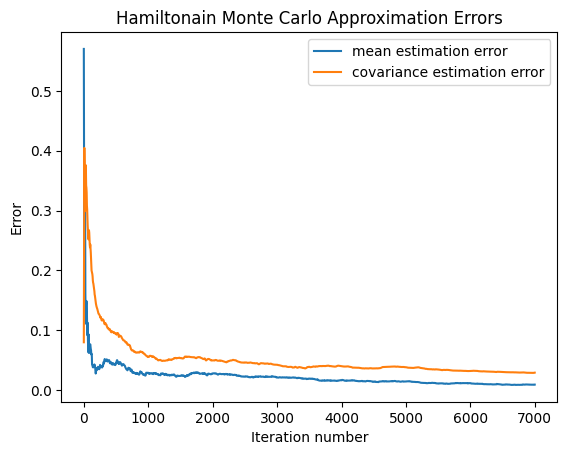

In [ ]:
mvn = MVN(tf.constant(large_scale_mean.tolist(),dtype=tf.float32), tf.constant(large_scale_cov.tolist(),dtype=tf.float32))
# print(mvn.getMean(),mvn.getCovariance())
chain_maker = HamiltonianChainMaker(mvn,n=10**4,step_size=.1)
print(chain_maker)
plot_chain_errors(large_scale_mean,large_scale_cov,chain_maker.getOutput(),"Hamiltonain Monte Carlo Approximation Errors")

In [ ]:
import numpy as np
from AM.am import AdaptiveMetropolis

def target_distribution(params):
    # mean = np.array([0, 0])
    # covariance = np.array([[5, 1], [0, 1]])
    mean = np.array(large_scale_mean)
    covariance = np.array(large_scale_cov)
    inv_covariance = np.linalg.inv(covariance)
    exponent = -0.5 * np.dot(np.dot((params - mean).T, inv_covariance), (params - mean))
    return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(covariance)))
        
# Create an instance of AdaptiveMetropolis
initial_params = [0 for i in range(s)]
sd = 0.1  # Scaling parameter
epsilon = 1.0  # Parameter for the time-dependent covariance structure
t0 = 100  # Time index for transition in covariance structure
iterations = 7000
am_sampler = AdaptiveMetropolis(target_distribution, initial_params, sd, epsilon, t0, iterations)

am_sampler.getOutput()

array([[ 0.75161383, -0.17200258,  0.1381222 , ..., -0.79255763,
         0.94588556,  0.91522735],
       [ 0.75161383, -0.17200258,  0.1381222 , ..., -0.79255763,
         0.94588556,  0.91522735],
       [ 0.79520472,  0.04814078, -0.13845157, ..., -0.6243404 ,
         0.88024079,  1.67409354],
       ...,
       [ 0.52758931,  1.95347934,  1.29102019, ...,  1.45123334,
        -0.52193456,  2.32437146],
       [ 0.52758931,  1.95347934,  1.29102019, ...,  1.45123334,
        -0.52193456,  2.32437146],
       [-0.57772889,  1.57303311,  0.98861267, ...,  1.50451816,
         0.92137404,  1.98054241]])

In [ ]:
# Calculate and print the mean and variance for each dimension of the samples
mean_of_samples = np.mean(am_sampler.getOutput(), axis=0)
variance_of_samples = np.cov(np.array(am_sampler.getOutput()).T)
print(f"Mean of Samples: {mean_of_samples}")
print(f"Variance of Samples: {variance_of_samples}")

Mean of Samples: [ 0.07124948  1.5559416   0.85164918  0.81026909  1.75994954  0.20347611
 -0.00849295  1.39998752  1.29436736  2.23396663]
Variance of Samples: [[ 1.46464783e+00  6.64207967e-02 -9.10305611e-02  3.67868498e-02
   5.05804506e-04  8.21330703e-03 -1.06680112e-01 -2.10091854e-02
  -4.70754049e-02 -4.05472179e-02]
 [ 6.64207967e-02  1.32092503e+00 -7.04753415e-02  4.73069966e-02
   3.99964027e-02 -1.24234183e-02 -1.36942532e-01 -1.00209813e-01
   1.29917481e-01  1.34446382e-02]
 [-9.10305611e-02 -7.04753415e-02  3.82114896e-01 -5.41581630e-02
  -5.43677704e-02  2.41464808e-02  1.60392330e-02 -2.39331030e-02
  -3.50420180e-02  7.98731517e-03]
 [ 3.67868498e-02  4.73069966e-02 -5.41581630e-02  2.04073443e+00
   5.54683339e-02  3.50899875e-02 -9.74627517e-02  1.03287444e-01
   2.15284370e-01 -1.08533018e-02]
 [ 5.05804506e-04  3.99964027e-02 -5.43677704e-02  5.54683339e-02
   6.67930720e-01  1.87440121e-02 -2.74891699e-03 -5.34160940e-02
  -4.22971680e-02  6.24108636e-03]
 [ 8

[ 0.85715246  0.93932946 -0.35381233 -1.1225698   2.23344412 -1.15324906
  1.19964756 -0.19050806  0.94214727  1.73602669] [[ 0.39472938 -0.05205274 -0.05010249  0.0412932   0.03600382  0.17338171
  -0.18506724 -0.10767209  0.0368508   0.07223877]
 [-0.05205274  1.97950545 -0.30370464 -0.70842677  1.07219899  0.48392438
  -0.69822636  0.98678825  0.23794465  0.27289498]
 [-0.05010249 -0.30370464  0.17173984  0.17289554 -0.29099655 -0.03599107
   0.11717987 -0.1601996   0.03534837 -0.10175889]
 [ 0.0412932  -0.70842677  0.17289554  0.35969777 -0.42803107  0.02314321
   0.23167462 -0.37194346 -0.04186829 -0.1674705 ]
 [ 0.03600382  1.07219899 -0.29099655 -0.42803107  0.71466603  0.27095178
  -0.38979605  0.54150803  0.05603214  0.19511873]
 [ 0.17338171  0.48392438 -0.03599107  0.02314321  0.27095178  0.57456392
  -0.2667704   0.18634103  0.11251569 -0.02719421]
 [-0.18506724 -0.69822636  0.11717987  0.23167462 -0.38979605 -0.2667704
   0.35530896 -0.30237964 -0.11998543 -0.13267344]
 [-

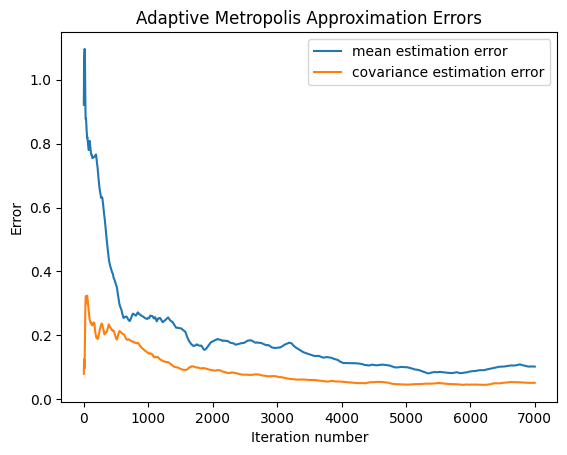

In [ ]:
plot_chain_errors(large_scale_mean,large_scale_cov,am_sampler.getOutput(),"Adaptive Metropolis Approximation Errors")

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

In [ ]:

# Two-dimensional target distribution function
def target_distribution(x):
    # mean = np.array([0, 0])
    # covariance = np.array([[5, 1], [0, 1]])
    mean = np.array(large_scale_mean)
    covariance = np.array(large_scale_cov)
    inv_covariance = np.linalg.inv(covariance)
    exponent = -0.5 * np.dot((x - mean), np.dot(inv_covariance, (x - mean)))
    return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(covariance)))


# Proposal distribution for two-dimensional theta
def proposal_distribution(theta, sigma=0.5):
    return theta + np.random.normal(0, sigma, size=theta.shape)

# Function to compute correction factor
def compute_correction_factor(num_points, sigma):
    def objective(C_sigma):
        convolved = np.convolve(stats.norm.cdf(np.linspace(-3*sigma, 3*sigma, num_points)/sigma), C_sigma, mode='same')
        S = 1 / (1 + np.exp(-np.linspace(-3*sigma, 3*sigma, num_points)))
        return np.sum(np.abs(convolved - S))

    initial_guess = np.ones(num_points) / num_points
    result = minimize(objective, initial_guess, method='SLSQP')
    return np.mean(result.x) if result.success else 1.0

# Function to create correction distribution
def create_correction_distribution_function(average_correction_factor, scale=1):
    def correction_distribution():
        return np.random.normal(average_correction_factor, scale)
    return correction_distribution

# Function to compute statistics (Δ*, sample variance, error)
def compute_statistics(current, proposed, minibatch, target_distribution):
    lambda_values = []
    for x in minibatch:
        current_density = target_distribution(current)
        proposed_density = target_distribution(proposed)
        lambda_value = np.log(proposed_density / current_density)
        lambda_values.append(lambda_value)
    lambda_values = np.array(lambda_values)

    delta_star = np.mean(lambda_values)
    sample_variance = np.var(lambda_values)

    # First and third moments for error estimation
    first_moment = np.mean(np.abs(lambda_values - delta_star))
    third_moment = np.mean(np.abs(lambda_values - delta_star)**3)

    # Error estimate
    error = (6.4 * third_moment / np.sqrt(len(minibatch))) + (2 * first_moment / len(minibatch))
    return delta_star, sample_variance, error


# Minibatch acceptance test function
def minibatch_acceptance_test(current, proposed, minibatch, target_distribution, correction_distribution, delta_threshold, error_tolerance):
    global final_minibatch_size
    delta_star, sample_variance, error = compute_statistics(current, proposed, minibatch, target_distribution)
    while sample_variance >= 1 or error > error_tolerance:
        additional_samples = np.random.choice(data, m, replace=False)
        minibatch = np.concatenate((minibatch, additional_samples))
        delta_star, sample_variance, error = compute_statistics(current, proposed, minibatch, target_distribution)
    final_minibatch_size = len(minibatch)
    X_nc = np.random.normal(0, np.sqrt(1 - sample_variance))
    X_corr = correction_distribution()
    return delta_star + X_nc + X_corr > 0

# MCMC sampling with minibatches for two-dimensional theta
def mcmc_with_minibatch(T, m, delta, correction_distribution, initial_sample, proposal_distribution, target_distribution, data):
    samples = [initial_sample]
    theta = initial_sample
    accepted = 0

    for _ in range(T):
        theta_prime = proposal_distribution(theta)
        minibatch_indices = np.random.choice(len(data), m, replace=False)
        minibatch = data[minibatch_indices]

        if minibatch_acceptance_test(theta, theta_prime, minibatch, target_distribution, correction_distribution, 1, delta):
            theta = theta_prime
            accepted += 1
        samples.append(theta)

    acceptance_rate = accepted / T
    print(f"Acceptance Rate: {acceptance_rate}")
    return samples

# Prepare the dataset and parameters
final_minibatch_size = 0
T = 8000  # Reduced number of samples for speed
m = 5   
iters = T
delta = 0.1  # Error bound
average_correction_factor = compute_correction_factor(num_points=100, sigma=0.5)
correction_distribution = create_correction_distribution_function(average_correction_factor)
initial_sample = np.array([0 for i in range(s)])  # Starting point in the parameter space
data = np.random.normal(0, 1, (2000, s))  # Simulated dataset

# Run the Metropolis-Hastings algorithm
samples = mcmc_with_minibatch(iters, m, delta, correction_distribution, initial_sample, proposal_distribution, target_distribution, data)


# Calculate and print the mean and variance for each dimension of the samples
mean_of_samples = np.mean(samples, axis=0)
variance_of_samples = np.cov(np.array(samples).T)
print(f"Mean of Samples: {mean_of_samples}")
print(f"Variance of Samples: {variance_of_samples}")


Acceptance Rate: 0.30275
Mean of Samples: [0.11974779 1.68800723 0.78869689 0.69695695 1.674938   0.23663143
 0.12567955 1.44860884 1.17884092 2.25181598]
Variance of Samples: [[ 1.78171301e+00  6.50604305e-02  2.63807330e-02  1.24491497e-02
  -1.45502075e-02 -4.03625105e-02  7.30068354e-02  2.77653414e-03
   6.02493562e-02 -3.12972431e-02]
 [ 6.50604305e-02  1.36235923e+00  3.74953706e-02 -6.57244045e-02
  -3.14952021e-02  5.80050703e-02  7.10496153e-03  8.59800003e-03
   1.22987998e-01  7.14299243e-03]
 [ 2.63807330e-02  3.74953706e-02  4.77542491e-01  1.49601334e-01
  -2.65114293e-02  1.04310653e-02 -1.51837949e-02 -4.71523947e-02
   6.06347341e-02 -2.43716250e-03]
 [ 1.24491497e-02 -6.57244045e-02  1.49601334e-01  2.06873218e+00
  -2.92303044e-02 -7.71849855e-02 -4.28345333e-02  3.86197576e-02
   1.38574909e-01  1.36622937e-02]
 [-1.45502075e-02 -3.14952021e-02 -2.65114293e-02 -2.92303044e-02
   8.86502025e-01 -1.29400002e-02 -4.00573363e-02  1.54332318e-01
  -8.21408743e-02  1.117

In [ ]:
samples

[array([0, 0]),
 array([ 0.1157987 , -0.30676848]),
 array([ 0.35444572, -0.137657  ]),
 array([ 0.35444572, -0.137657  ]),
 array([ 1.00308602, -0.44525596]),
 array([ 0.99025889, -0.14219208]),
 array([ 0.99025889, -0.14219208]),
 array([ 1.85904966, -0.07666144]),
 array([ 2.06813916, -0.15996488]),
 array([1.75529409, 0.66683718]),
 array([1.75529409, 0.66683718]),
 array([2.74833262, 0.25790122]),
 array([2.25460426, 0.19130659]),
 array([ 2.08565576, -0.72652928]),
 array([ 2.08565576, -0.72652928]),
 array([ 2.32723576, -0.66710223]),
 array([ 1.85186553, -1.30394624]),
 array([ 1.85186553, -1.30394624]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.68040645, -0.69722603]),
 array([ 1.93619353, -0.47699266]),
 array([ 1.70788709, -0.33385384]),
 array([ 1.8024772 , -0.55903673]),
 array([1.52652129, 0.63790081]),
 array([1.23348702, 0.55654849]),
 array([0.32105244, 0.90

[ 1.24383732  0.70190213  0.04038403  0.4724923  -0.7449442  -0.82173019
  0.06318964 -0.8749352   0.00816614  1.2379177 ] [[ 0.32352122  0.06199364 -0.05622     0.07662265 -0.11981879 -0.2078089
   0.09756848 -0.1297212   0.06133342  0.26093839]
 [ 0.06199364  0.20535917  0.11337073  0.07826641 -0.03658333 -0.07140797
  -0.04674438 -0.04566423  0.11281994  0.15910322]
 [-0.05622     0.11337073  0.19202342  0.05089619 -0.00179162  0.03333001
  -0.05845953  0.03036981  0.13617498  0.13967869]
 [ 0.07662265  0.07826641  0.05089619  0.10796997 -0.0713854   0.00934604
   0.00211432  0.01497484  0.1690917   0.17728169]
 [-0.11981879 -0.03658333 -0.00179162 -0.0713854   0.08594611  0.0414924
  -0.0248083   0.04286455 -0.0582919  -0.13413329]
 [-0.2078089  -0.07140797  0.03333001  0.00934604  0.0414924   0.21195592
  -0.04948649  0.13109174  0.05057544 -0.10920573]
 [ 0.09756848 -0.04674438 -0.05845953  0.00211432 -0.0248083  -0.04948649
   0.0740053  -0.03107148 -0.03459553  0.00967171]
 [-0

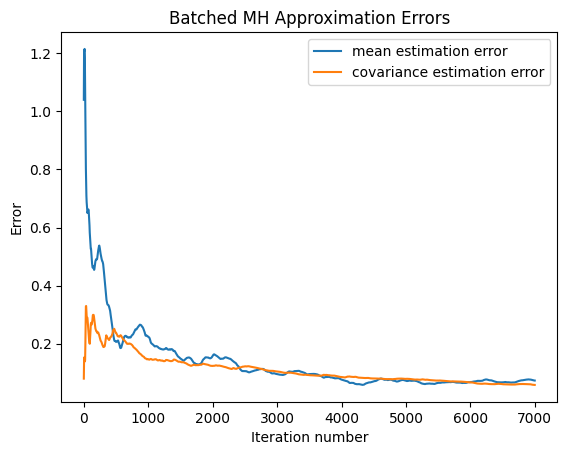

In [ ]:
plot_chain_errors(large_scale_mean,large_scale_cov,np.array(samples),"Batched MH Approximation Errors")

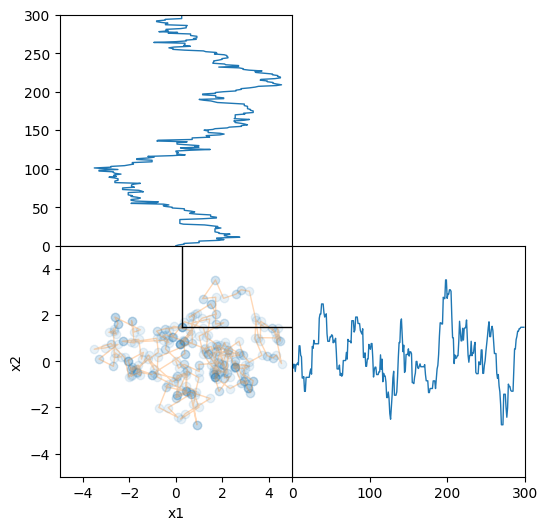

In [ ]:
from HMC.ChainVisualizers import visualize

class MiniBatchChain:
    def __init__(self,samples) -> None:
        self.samples = np.array(samples)

    def getOutput(self):
        return self.samples
minibatch_chain = MiniBatchChain(samples)

In [ ]:
from dram import DRAM
import numpy as np
def target_distribution(params):
    # mean = np.array([0, 0])
    # covariance = np.array([[5, 1], [0, 1]])

    mean = np.array(large_scale_mean)
    covariance = np.array(large_scale_cov)
    inv_covariance = np.linalg.inv(covariance)
    exponent = -0.5 * np.dot(np.dot((params - mean).T, inv_covariance), (params - mean))
    return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(covariance)))
        
# Create an instance of DelayedRejectionMCMC
initial_params = [0 for i in range(s)]
iterations = 8000
t0 = 100
dram_sampler = DRAM(target_distribution, initial_params, iterations, t0)

# dram_sampler.getOutput()
dram_sampler.run()

array([[ 0.51120255, -0.33385699,  0.3172312 , ...,  0.2286137 ,
         0.08870501,  0.70934426],
       [ 0.51120255, -0.33385699,  0.3172312 , ...,  0.2286137 ,
         0.08870501,  0.70934426],
       [ 0.51120255, -0.33385699,  0.3172312 , ...,  0.2286137 ,
         0.08870501,  0.70934426],
       ...,
       [ 0.9222505 ,  1.18832112,  1.27333865, ...,  1.04791538,
         1.68869083,  2.31962639],
       [ 0.99691742,  1.46389775,  1.11713174, ...,  1.09929929,
         1.75565031,  2.30672557],
       [ 0.9639336 ,  1.35368865,  1.18139945, ...,  1.08080706,
         1.72976121,  2.31341722]])

In [ ]:
# Calculate and print the mean and variance for each dimension of the samples
mean_of_samples = np.mean(np.array(dram_sampler.samples), axis=0)
variance_of_samples = np.cov(np.array(dram_sampler.samples).T)
print(f"Mean of Samples: {mean_of_samples}")
print(f"Variance of Samples: {variance_of_samples}")

Mean of Samples: [ 0.78661783  0.34216409  1.82435944 -0.19438631  2.25584557  0.84734879
 -0.86104365  0.81687581  1.1621798   2.13151325]
Variance of Samples: [[ 0.05606598  0.03784428 -0.02037823 -0.01348309 -0.02744154 -0.00995352
   0.02139826 -0.02804317  0.03544526  0.0250828 ]
 [ 0.03784428  0.2114657  -0.08712413 -0.09863832 -0.00025388 -0.06359268
   0.14036385  0.06689292  0.11836968  0.03761939]
 [-0.02037823 -0.08712413  0.07900883  0.05138197 -0.02019328  0.02760235
  -0.09572542 -0.03961006 -0.05740818 -0.0157347 ]
 [-0.01348309 -0.09863832  0.05138197  0.15904323  0.01382107  0.04193514
  -0.16444748 -0.05638029 -0.02965809  0.00148798]
 [-0.02744154 -0.00025388 -0.02019328  0.01382107  0.07909642  0.00123451
   0.03013535  0.03036319  0.00094551  0.00491459]
 [-0.00995352 -0.06359268  0.02760235  0.04193514  0.00123451  0.03116331
  -0.05139191 -0.03007299 -0.02674738 -0.00970718]
 [ 0.02139826  0.14036385 -0.09572542 -0.16444748  0.03013535 -0.05139191
   0.22188643  

[ 1.13456874  1.28438329  2.64256046 -1.89653997 -1.36000296  0.02062862
 -1.32946755  0.88979954  1.0209375   1.72108636] [[ 0.62992241  0.17757182  0.01619679  0.04622411  0.57901731 -0.02770138
  -0.03189006 -0.22320916 -0.22454151  0.17681178]
 [ 0.17757182  0.57985208  0.62032626 -0.49821192  0.22753489  0.36517234
  -0.16896979  0.44688293 -0.04128299  0.21061807]
 [ 0.01619679  0.62032626  1.04095433 -0.43772834  0.35856187  0.71900047
  -0.18581768  0.20883159  0.50070714  0.36247694]
 [ 0.04622411 -0.49821192 -0.43772834  0.6310787   0.24380875 -0.12473981
   0.20994856 -0.81420244  0.10165833 -0.0609437 ]
 [ 0.57901731  0.22753489  0.35856187  0.24380875  1.07139278  0.47057456
   0.07082718 -0.73165614 -0.00681386  0.33870988]
 [-0.02770138  0.36517234  0.71900047 -0.12473981  0.47057456  0.70387121
   0.00354818 -0.18283849  0.29485969  0.22618847]
 [-0.03189006 -0.16896979 -0.18581768  0.20994856  0.07082718  0.00354818
   0.1208274  -0.27182329 -0.08310561 -0.08332776]
 [

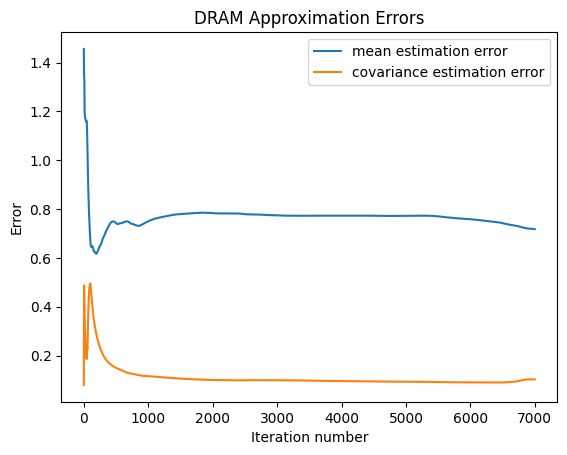

In [ ]:
plot_chain_errors(large_scale_mean,large_scale_cov,np.array(dram_sampler.samples),"DRAM Approximation Errors")